# Generalities

In [ ]:
# !pip install hurst
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import time
import warnings
import threading
import gc
from hurst import compute_Hc
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# import torch.nn as nn
# import torch
# from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

In [ ]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''

In [ ]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [ ]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')
train.head(10)

In [ ]:
# dataframe dimensiosn
print(train.shape)

def pl_replace(df, replace_dict):
    return df.with_columns(pl.all().replace(replace_dict))

# For eeg data
def loadeeg(path):
    eeg = pl.read_parquet(path)
    # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    eeg = eeg.fill_null(0)
    eeg = eeg.fill_nan(0)
    return (eeg)

# For spectrograms
def loadspect(GET_ROW):
    
    row = train.iloc[GET_ROW]
#     Needs to be changed to match the eeg function
    spectrogram = pl.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
    spec_offset = int( row.spectrogram_label_offset_seconds )
    spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                         &(spectrogram.time<spec_offset+600)]
    time = (np.linspace(0,600,spectrogram.shape[0])) - 25

    return (row,spectrogram,time)

# Compute time domain features

In [ ]:
# Initialise a few things
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
start = np.argmin(np.abs(time_eeg+5))
stop = np.argmin(np.abs(time_eeg-5))

train_grby = train.groupby("eeg_id")

In [ ]:
# there is indeed a problem with PCA as we initially used it. We can't compared component 1 for subject 1 with component 1 for subject 2
# and assume its the same variable. Instead, I suggest to use frontal, medial and postrior components, and left, medial and right components
# We can't use PCA trained with seizure and other brain dysfunction because we won't have access to this information in the test set, so we won't be 
# able to select which PCA model to use for which eeg_id in the test set. 


loc = {"frontal": ["F3", "Fp1", "Fz", "Fp2", "F4"],
       "occipital": ["O1", "P3", "Pz", "P4", "O2"],
       "left": ["F7", "T3", "C3", "T5"],
       "right": ["F8", "T4", "C4", "T6"]}
# + Cz alone for the central component without PCA
# 3 components per category + Cz + Ekg = 14 features. 

i = 0

path = f'{EEG_PATH}{1628180742}.parquet'
fulleeg = loadeeg(path)
print(fulleeg.columns)
print(fulleeg.shape)

for i in loc:
    eeg = fulleeg[loc[i]]

    n_comp = len(eeg.columns)
    pca = PCA(n_comp)
    pcafit = pca.fit_transform(eeg)
    
    pca.explained_variance_ratio_
    ev = np.cumsum(pca.explained_variance_ratio_)
    ev = np.append(ev[::-1], 0)
    ev = ev[::-1]
    
    plt.plot(range(0,n_comp+1),ev, "b-")
    plt.title(i)
    plt.xlabel('Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()
    plt.close()

# selection 8 components for ~97.5% of the explained variance

In [ ]:
class cThreadParams():
    def __init__(self):
        threading.Thread.__init__(self)
        self.next = 0

def run_file_opener(thread):
    file_id = train.eeg_id.unique()[min(count+1,17088)]
    path = f'{EEG_PATH}{file_id}.parquet'
    thread.next = loadeeg(path)
    thread.next = thread.next.with_row_index(offset = 0)

In [ ]:
def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out

In [ ]:
# SVD Entropy
# eeg_z = (eeg_seg-eeg_seg.mean())/eeg_seg.std()
#u, s, v = np.linalg.svd(eeg_z, full_matrices=True)
# s = s/np.sum(s)
#TD_Features.loc[i, channels+"_SVDEn_"+ segment_names[seg]] = -(s*np.log(s)).sum()
# linelength['SVDEn' + seg] = SVDEn

# # Entropy
# add = eeg.sum()
# eegnorm = eeg/add
# entropy = -(eegnorm*np.log(eegnorm)).sum() # There may be problems here with the log.
# entropy.index = entropy.index + '_entropy' + seg
# entropy = entropy.to_frame().transpose()

# Hurst Exponent
# hurst = []
#for idx,channel in enumerate(eeg.keys()):
#    h, c, data = compute_Hc(eeg[channel], simplified=True)
#    hurst.append(h)
# hurst = pd.DataFrame([np.array(hurst).reshape(-1)], columns=(eeg.keys()+ 'hurst' + seg))

In [ ]:
channels_id = pd.Series(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
segment_names = {0:"_BeforeAfter",1:"_During"}
var = ['eeg_label_offset_seconds']

start = 850
n_parquet = 1700 # 0:170 is ~1% of the dataset
mask = train.eeg_id.isin(train.eeg_id.unique()[0:n_parquet])
TD_Features_wf = train.loc[mask, ['eeg_id']].copy()
TD_Features_lf_gr = pl.DataFrame()
TD_Features_lf_all = pl.DataFrame()

# polars functions with columns, and makes it harder to replace values of a single row. It requires to always change the entire column, 
# and the python code to do so is heavy. To avoid it, I have created a predefined numpy array called "segment_col" with the values of 
# the "segments" column (-1,0,1). For each eeg dataset, I will simply add a new column containing all the predefined numpy values. 
segment_col = np.ones(len(time_eeg))
mask = time_eeg < -5
segment_col[mask] = 0
mask = time_eeg > 5
segment_col[mask] = 0

t = time.time()

params = cThreadParams()

count = start-1
thr = threading.Thread(target=run_file_opener, args=(params,))
thr.start()
time.sleep(2)

fail = {}

for count0, id in enumerate(train.eeg_id.unique()[start:n_parquet]):
    count = count0 + start
    if count%10 == 0: 
        print(count, int(time.time()-t))
        gc.collect()
    
    thr.join()
    pcaeeg = params.next.clone()
    # print(count, pcaeeg.shape)

    thr = threading.Thread(target=run_file_opener, args=(params,))
    thr.start()
    
    for i, offset in train_grby.get_group(id)[var].itertuples():

        eeg = pcaeeg.filter((pl.col("index") >= offset*200) & (pl.col("index") <= (offset+50)*200)).clone()
        
        if eeg.shape[0] >9999:

            eeg = eeg.with_columns(pl.Series("segments", np.zeros(eeg.shape[0])))
            eeg_by_seg = eeg.group_by('segments')
            
            features_all = eeg_by_seg.agg(pl.exclude("index").mean().name.suffix("_mean_all"),
                              pl.exclude("index").std().name.suffix("_std_all"),
                              pl.exclude("index").kurtosis().name.suffix("_kurt_all"),
                              pl.exclude("index").skew().name.suffix("_skew_all"),
                              (pl.exclude("index").max()-pl.exclude("index").min()).name.suffix("_rng_all"),
                              pl.exclude("index").diff().abs().sum().name.suffix("_linelength_all"),
                              pl.exclude("index").pow(2).mean().pow(0.5).name.suffix("_rms_all"),
                              pl.exclude("index").apply(lambda x: hurst_fct(x)).name.suffix("_hurst_all"))
            
            eeg = eeg.replace("segments", pl.Series(segment_col[0:eeg.shape[0]]))
            eeg_by_seg = eeg.group_by('segments')
    
            features_gr = eeg_by_seg.agg(pl.exclude("index").mean().name.suffix("_mean"),
                              pl.exclude("index").std().name.suffix("_std"),
                              pl.exclude("index").kurtosis().name.suffix("_kurt"),
                              pl.exclude("index").skew().name.suffix("_skew"),
                              (pl.exclude("index").max()-pl.exclude("index").min()).name.suffix("_rng"),
                              pl.exclude("index").diff().abs().sum().name.suffix("_linelength"),
                              pl.exclude("index").pow(2).mean().pow(0.5).name.suffix("_rms"),
                              pl.exclude("index").apply(lambda x: hurst_fct(x)).name.suffix("_hurst"))


            TD_Features_lf_all = pl.concat([TD_Features_lf_all, features_all])
            TD_Features_lf_gr = pl.concat([TD_Features_lf_gr, features_gr])

        else: 
            if id not in fail.keys():
                fail[id] = []
            fail[id].append(offset)
            print(count, id, eeg.shape, offset)

thr.join()

print(f"Running time: {time.time()-t} s")

# It took me 11h20 to compute the features for the first 1700 parquet files (~10%) and 11436 lines (10.7%)
# Thats more than 100 hours in total for all files, hence the need to reduce number of features and use PCA

In [ ]:
TD_Features_lf_all.write_csv(f"{DIRECTORY}TD_Features_lf_all_{start}-{n_parquet}.csv")
TD_Features_lf_gr.write_csv(f"{DIRECTORY}TD_Features_lf_gr.csv")

In [ ]:
TD_Features_wf = pl.DataFrame()

for i in [0,1]:
    colnames = pl.Series(TD_Features_lf_gr.columns) + segment_names[i]
    copyTDF_lf = TD_Features_lf_gr.clone().filter(pl.col('segments') == i)
    copyTDF_lf.columns = colnames
    TD_Features_wf = pl.concat([TD_Features_wf, copyTDF_lf], how = "horizontal")

TD_Features_wf = TD_Features_wf.drop(["segments_BeforeAfter", "segments_During"])

TD_Features_lf_all = TD_Features_lf_all.drop(["segments"])

In [ ]:
TD_Features_wf = pl.concat([TD_Features_wf, TD_Features_lf_all], how = "horizontal")
TD_Features_wf.write_csv(f"{DIRECTORY}TD_Features_wf_Basemodel_{start}-{n_parquet}.csv")

In [ ]:
train0 = pd.read_csv(DIRECTORY + 'train.csv')
train = pd.read_csv(DIRECTORY+"TD_Features_wf_BaseModel_0-1700.csv")

In [ ]:
mask = train0.eeg_id.isin(train0.eeg_id.unique()[0:1700])
mask.value_counts()
train0_mask = train0.loc[mask, :].reset_index(drop = True).copy()
train = train.reset_index(drop = True)
train = pd.concat([train0_mask, train], axis = 1)
print(train.shape)
train.tail()

In [ ]:
train.to_csv(DIRECTORY+"TD_Features_wf_BaseModel_0-1700.csv", index = False)

# Baseline Model Building

# Exploration

In [ ]:
import xgboost as xgb
from keras.losses import KLDivergence
from scipy.stats import entropy
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss

In [ ]:
train = pd.read_csv(DIRECTORY+"TD_Features_wf_BaseModel_0-1700.csv")
print(train.shape)
train.head()

In [ ]:
# A bit of exploration
print("\nnumber of unique eeg ids:", len(train.eeg_id.unique()))
# Not sure if there is a way to use patient id in the model because patients will likely differ between the train set and the test set.
# We could perhaps use a two stage process: first make predictions without patient id, then calculate the mean ID per patient and lastly retrain
# the model with the mean_by_patient. We can also do the same with eeg_id
print("\nnumber of unique patient ids:", len(train.patient_id.unique()))
print("\n", train.expert_consensus.value_counts())

votes_var = ['seizure_vote', 'lpd_vote','gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

fig, axes = plt.subplots(2, 3, figsize = (8, 3), sharey = True)
for i, var in enumerate(votes_var):
    axes[i%2, i//2].hist(train[var], bins = 40)
    axes[i%2, i//2].set_title(var)
fig.tight_layout()
plt.show()
plt.close()

In [ ]:
train.Pattern_detail.value_counts()

In [ ]:
# Encoding categorical features
categorical_vars = train.select_dtypes(include=['object'])
# encoding
encoding_dict = {}
decoding_dict = {}
for i in categorical_vars.columns:
    encoding_dict[i] = {}
    decoding_dict[i] = {}
    code = -1
    for j in categorical_vars[i].unique():
        code += 1
        encoding_dict[i][j] = code
        decoding_dict[i][code] = j
        train[i] = train[i].replace(j, code)

print("encoding dictionary:", encoding_dict)
print("\ndecoding dictionary:", decoding_dict)

In [ ]:
# select all variables with BeforeAfter
BAlist = []
for col in train.columns:
    if "BeforeAfter" in col:
        BAlist.append(col)
print(BAlist)

In [ ]:
drop_var = ['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote', 'Total_votes', 
        'Pattern', 'Pattern_detail'] + BAlist

# ytrain columns should be in the encoding order: 0'Seizure', 1: 'GPD', 2: 'LRDA', 3: 'Other', 4: 'GRDA', 5: 'LPD'
ytrain_df = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
ytrain = train["expert_consensus"].copy()
Xtrain = train.drop(drop_var, axis = 1).copy()
print(Xtrain.shape)
print(ytrain_df.shape)
print(ytrain.shape)

In [ ]:
# if above 2.0, there should be some work-in-progress support for multi-output classification and regression
print(f"XGBoost version: {xgb.__version__}")
#
print(f"LightGBM version: {lgb.__version__}")

In [ ]:
# KL divergence as described on the competition's main page: https://www.kaggle.com/code/metric/kullback-leibler-divergence/notebook
# I have noticed that it sometimes return negative values, which is a problem.

# not sure how sample_weights work so I have disabled it.
def kl_divergence(solution, submission, epsilon = 1e-15, micro_average = False, sample_weights = None):
    if not isinstance(solution, pd.DataFrame): solution = pd.DataFrame(solution)
    if not isinstance(submission, pd.DataFrame): submission = pd.DataFrame(submission)   

    for col in solution.columns:

        if not pd.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0 
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * \
                                                np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1))#, weights=sample_weights)
    else:
        return np.average(solution.mean())


# test function
a = np.array([[0,0.454545,0,0.454545,0.090909,0],[1,0,0,0,0,0]])
b = np.array([[0.004623, 0.014689, 0.001511, 0.972723, 0.001024, 0.005430],
             [0.665518, 0.070153, 0.003781, 0.239425, 0.004530, 0.016593]])
a = pd.DataFrame(a)
b = pd.DataFrame(b)

# micro_average True and False don't give the same results, but I don't know which one should be used.
kld = kl_divergence(a, b, 1e-15, False, None)
print(kld)
kld = kl_divergence(a, b, 1e-15, True, None)
print(kld)

In [ ]:
# KLdivergence should not be definite when Q(i) = 0 and P(i) = 0, which is the case in almost all rows in our dataset. 
# the choice of the KL divergence in this competition is a problem. They tried to solve it by using a heuristic:
# ignoring the cells where Q(i) = 0 and tranforming P(i) = 1e-15 instead of 0. However, there is still an issue because the 
# sum of P(i) for all P ends up not summing to one because of the ignored cells with Q(i) = 0. I think that's the reason why there are
# occasionally negative KLD. 


def log(x):
    x[x == 0] = 1e-15
    x[x == 1] = 1-1e-15
    return np.log(x)

def JensenShannonDiv(true_y, pred_y): # Jensen-Shannon Divergence https://towardsdatascience.com/how-to-understand-and-use-jensen-shannon-divergence-b10e11b03fd6
    #if not isinstance(true_y, pd.DataFrame): true_y = pd.DataFrame(true_y)
    # if not isinstance(pred_y, pd.DataFrame): pred_y = pd.DataFrame(pred_y)
    # removing 0 to avoid divisions by 0.
    true_y[true_y == 0] = 1e-15
    # sum to 1
    true_y = true_y.T / np.sum(true_y, axis = 1)
    true_y = true_y.T
    pred_y = pred_y.T / np.sum(pred_y, axis = 1)
    pred_y = pred_y.T
    JSD1 = pred_y*log(2* pred_y/ (pred_y+true_y))
    JSD2 = true_y*log(2* true_y/ (pred_y+true_y))
    JSD = 0.5*np.sum(JSD1, axis = 1) + 0.5*np.sum(JSD2, axis = 1)
    return np.nanmean(JSD)

# test function
a = np.array([[0,0.454545,0,0.454545,0.090909,0],[1,0,0,0,0,0]])
b = np.array([[0.004623, 0.014689, 0.001511, 0.972723, 0.001024, 0.005430],
             [0.665518, 0.070153, 0.003781, 0.239425, 0.004530, 0.016593]])

jsd = JensenShannonDiv(a, b)
print(jsd)

In [ ]:
# test metrics
def custom_CV_lgb(X, y, y_df, params, n_splits = 5):
    CV_predictions_df = pd.DataFrame(np.zeros([len(y),6]))
    CV_predictions = pd.Series(np.zeros(len(y)))
    
    unique_eeg_id = pd.Series(train.eeg_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_eeg_id)
    mykFolds = enumerate(skfold.split(unique_eeg_id))

    LGBM = lgb.LGBMClassifier(**params)
    
    for i, (train_idx, test_idx) in mykFolds:
        mask = train.eeg_id.isin(unique_eeg_id.iloc[train_idx])
        X_train = X.loc[mask,:]
        y_train = y.loc[mask]
        X_test = X.loc[~mask,:]
        y_test = y.loc[~mask]

        LGBM.fit(X_train, y_train)
        pred_proba = LGBM.predict_proba(X_test)
        pred = LGBM.predict(X_test)
          
        # build CV results
        CV_predictions.iloc[~mask] = pred
        CV_predictions_df.iloc[~mask,:] = pred_proba
        gc.collect()

    acc = accuracy_score(y, CV_predictions)
    print(f"LGBM accuracy: {acc}")
    logloss = log_loss(y, CV_predictions_df)
    print(f"LGBM log loss: {logloss}")
    kld = kl_divergence(y_df.values, CV_predictions_df.values)
    print(f"LGBM competition KLD, no micro average: {kld}")
    kld = kl_divergence(y_df.values, CV_predictions_df.values, micro_average = True)
    print(f"LGBM competition KLD, with micro average: {kld}")
    KL = KLDivergence()
    kld = KL(y_df.values,  CV_predictions_df.values).numpy()
    print(f"LGBM keras KLD: {kld}")
    jsd = JensenShannonDiv(y_df.values, CV_predictions_df.values)
    print(f"LGBM custom JSD: {jsd}")
    return kld


# The metric kullback_leibler exists, but I could not find with which objective it works.
params = {'objective': 'multiclass',
    'metric': 'multi_logloss', # kullback_leibler?
    'num_classes': 6,
    'max_depth': 8,
    'num_leaves': 20,
    'learning_rate': 0.3,
    'n_estimators':200,
    'colsample_bytree': 0.2,
    'bagging_fraction': 0.2,
    'reg_alpha': 1,
    'reg_lambda': 9,
    'max_bin':50,
    'device_type': 'gpu',
    'verbose':-1}

res = custom_CV_lgb(Xtrain, ytrain, ytrain_df, params, n_splits = 5)
# I get erratic results when I run the function multiple times with this untuned modeL. 
# competition KLD and keras KLD sometimes have negative results, so I would not trust them.

In [ ]:
# this method of using a custom loss function and custom metrics does not seem so efficient. 
# I think that we'll get better results by using one model per target column
def custom_objective(predt, dtrain):
    predt[predt == 0] = 1e-15
    predt[predt == 1] = 1-6e-15
    # summing to 1 per row
    predt = predt.T / np.sum(predt, axis = 1)
    predt = predt.T
    # 2D reconstruction of y
    y = dtrain.get_label().reshape(predt.shape)
    # first order derivative: (px * qx/px)
    # grad = np.sum( predt * y / predt , axis = 1).T
    grad = predt * y / predt
    grad = grad.reshape(grad.size)
    # second order derivative: (px-qx)/px
    # hess = np.sum( (predt - y) / predt, axis = 1).T
    hess = (predt - y) / predt
    hess = hess.reshape(predt.size)
    return grad, hess

def KLD_metric(predt, dtrain):
    y = dtrain.get_label().reshape(predt.shape)
    y[y == 0] = 1e-15
    # adjusting values so that it sums to 1 per row
    y = y.T / np.sum(y, axis = 1)
    y = y.T
    predt = np.clip(predt,0,1)
    predt = predt.T / np.sum(predt, axis = 1)
    predt = predt.T
    # KLD
    KLD = np.sum(predt*log(predt/Nodiv0(y)), axis = 1)
    return "KLD", float(np.nanmean(KLD))

X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain_df, test_size = 0.2)

strategy = "one_output_per_tree" # "multi_output_tree" # one_output_per_tree <- better
# results: Dict[str, Dict[str, List[float]]] = {}
results = {}

dtrain = xgb.DMatrix(X_train, y_train)
dtest= xgb.DMatrix(X_test, y_test)
model = xgb.train({
    "tree_method": "hist",
    "num_target": ytrain_df.shape[1],
    "multi_strategy": strategy,
    "disable_default_eval_metric":1,
    'max_depth': 15,
    "booster": "gbtree",
    },
    num_boost_round = 100,
    dtrain = dtrain, 
    verbose_eval = 10,
    obj = custom_objective, 
    evals = [(dtrain, "dtrain")],
    evals_result = results,
    custom_metric = KLD_metric,
    )

print("end")

# Model Tuning 1

In [ ]:
# device type for Fabien
device_type = 'gpu'

In [ ]:
# device type for Ketan
device_type = 'cpu'

In [4]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
from keras.losses import KLDivergence
from scipy.stats import entropy
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss, root_mean_squared_error

# load train set
train = pd.read_csv(DIRECTORY+"TD_Features_wf_BaseModel_0-1700.csv")
train = train.dropna().reset_index(drop = True)
print(train.shape)

# custom Jensen-Shannon Divergence function and dependencies
def log(x):
    x[x == 0] = 1e-15
    x[x == 1] = 1-1e-15
    return np.log(x)


def JensenShannonDiv(true_y, pred_y): # Jensen-Shannon Divergence https://towardsdatascience.com/how-to-understand-and-use-jensen-shannon-divergence-b10e11b03fd6
    #if not isinstance(true_y, pd.DataFrame): true_y = pd.DataFrame(true_y)
    # if not isinstance(pred_y, pd.DataFrame): pred_y = pd.DataFrame(pred_y)
    # removing 0 to avoid divisions by 0.
    true_y[true_y == 0] = 1e-15
    pred_y[pred_y == 0] = 1e-15
    # sum to 1
    true_y = true_y.T / np.sum(true_y, axis = 1)
    true_y = true_y.T
    pred_y = pred_y.T / np.sum(pred_y, axis = 1)
    pred_y = pred_y.T
    JSD1 = pred_y*log(2* pred_y/ (pred_y+true_y))
    JSD2 = true_y*log(2* true_y/ (pred_y+true_y))
    JSD = 0.5*np.sum(JSD1, axis = 1) + 0.5*np.sum(JSD2, axis = 1)
    return np.nanmean(JSD)


# competition metric? 
def kl_divergence(solution, submission, epsilon = 1e-15, micro_average = False, sample_weights = None):
    if not isinstance(solution, pd.DataFrame): solution = pd.DataFrame(solution)
    if not isinstance(submission, pd.DataFrame): submission = pd.DataFrame(submission)   

    for col in solution.columns:

        if not pd.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0 
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * \
                                                np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1))#, weights=sample_weights)
    else:
        return np.average(solution.mean())


# Encoding categorical features
categorical_vars = train.select_dtypes(include=['object'])
# encoding
encoding_dict = {}
decoding_dict = {}
for i in categorical_vars.columns:
    encoding_dict[i] = {}
    decoding_dict[i] = {}
    code = -1
    for j in categorical_vars[i].unique():
        code += 1
        encoding_dict[i][j] = code
        decoding_dict[i][code] = j
        train[i] = train[i].replace(j, code)

print("encoding dictionary:", encoding_dict)
print("\ndecoding dictionary:", decoding_dict)

# select all variables with BeforeAfter
BAlist = []
for col in train.columns:
    if "BeforeAfter" in col:
        BAlist.append(col)
# print(BAlist)

(11425, 498)
encoding dictionary: {'expert_consensus': {'Seizure': 0, 'GPD': 1, 'LRDA': 2, 'Other': 3, 'GRDA': 4, 'LPD': 5}, 'Pattern': {'Idealized': 0, 'Proto': 1, 'Edge': 2}, 'Pattern_detail': {'Idealized_seizure': 0, 'Proto_gpd': 1, 'Idealized_lrda': 2, 'Edge_seizure_gpd': 3, 'Proto_other': 4, 'Proto_lrda': 5, 'Edge_grda_gpd': 6, 'Idealized_grda': 7, 'Idealized_gpd': 8, 'Proto_seizure': 9, 'Idealized_lpd': 10, 'Edge_lpd_gpd': 11, 'Edge_grda_seizure': 12, 'Edge_gpd_grda': 13, 'Edge_gpd_seizure': 14, 'Proto_lpd': 15, 'Edge_gpd_lpd': 16, 'Proto_grda': 17, 'Edge_grda_lrda': 18, 'Edge_lrda_seizure': 19, 'Edge_lpd_lrda': 20, 'Edge_seizure_lrda': 21, 'Edge_lpd_seizure': 22, 'Edge_lrda_lpd': 23, 'Edge_grda_lpd': 24, 'Edge_seizure_lpd': 25, 'Edge_lrda_grda': 26, 'Edge_seizure_grda': 27, 'Edge_lpd_grda': 28}}

decoding dictionary: {'expert_consensus': {0: 'Seizure', 1: 'GPD', 2: 'LRDA', 3: 'Other', 4: 'GRDA', 5: 'LPD'}, 'Pattern': {0: 'Idealized', 1: 'Proto', 2: 'Edge'}, 'Pattern_detail': {0:

In [5]:
drop_var = ['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote', 'Total_votes', 
        'Pattern', 'Pattern_detail'] + BAlist

seizure_vote = train.seizure_vote.copy()
lpd_vote = train.lpd_vote.copy()
gpd_vote = train.gpd_vote.copy()
lrda_vote = train.lrda_vote.copy()
grda_vote = train.grda_vote.copy()
other_vote = train.other_vote.copy()

dict_y = {"seizure_vote": seizure_vote, 
          "lpd_vote": lpd_vote,
          "gpd_vote": gpd_vote,
          "lrda_vote": lrda_vote,
          "grda_vote": grda_vote, 
          "other_vote": other_vote}

Xtrain = train.drop(drop_var, axis = 1).copy()
print(Xtrain.shape)

(11425, 320)


In [6]:
def custom_CV_lgb(X, y, params, n_splits = 5):
    CV_predictions = pd.Series(np.zeros(len(y)))
    
    unique_patient_id = pd.Series(train.patient_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_patient_id)
    mykFolds = enumerate(skfold.split(unique_patient_id))

    LGBM = lgb.LGBMRegressor(**params)
    
    for i, (train_idx, test_idx) in mykFolds:
        mask = train.patient_id.isin(unique_patient_id.iloc[train_idx])
        X_train = X.loc[mask,:]
        y_train = y.loc[mask]
        X_test = X.loc[~mask,:]
        y_test = y.loc[~mask]

        LGBM.fit(X_train, y_train)
        pred = LGBM.predict(X_test)
          
        # build CV results
        CV_predictions.iloc[~mask] = pred
        gc.collect()

    results = root_mean_squared_error(y, CV_predictions)
    print(f"LGBM rmse: {results}")

    return results

In [7]:
best_params = {
"seizure_vote": # best rmse = 0.34917919183954 
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 17,
'num_leaves': 93,
'learning_rate': 0.03577726268513652,
'n_estimators': 376,
'colsample_bytree': 0.227727476691646,
'bagging_fraction': 0.639751550328699,
'reg_alpha': 0.7388876382357565,
'reg_lambda': 1.161591683472614,
'max_bin': 66,
'device_type': device_type,
'verbose':-1},

'lpd_vote': # best rmse = 0.292794499770596 
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 19,
'num_leaves': 61,
'learning_rate': 0.03589771561786665,
'n_estimators': 465,
'colsample_bytree': 0.5274178020614868,
'bagging_fraction': 0.4884222750632047,
'reg_alpha': 0.4203920671658803,
'reg_lambda': 2.5051661169483594,
'max_bin': 53,
'device_type': device_type,
'verbose':-1},

'gpd_vote': # best rmse = 0.2529527462818773
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 27,
'num_leaves': 74,
'learning_rate': 0.03319234099107125,
'n_estimators': 506,
'colsample_bytree': 0.1956979106423128,
'bagging_fraction': 0.7831885451295286,
'reg_alpha': 0.7208469805600042,
'reg_lambda': 4.790753164481859,
'max_bin': 28,
'device_type': device_type,
'verbose':-1},

'lrda_vote': # best rmse = 0.27898321999616355
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 30,
'num_leaves': 93,
'learning_rate': 0.03175824073191902,
'n_estimators': 289,
'colsample_bytree': 0.16061293358798023,
'bagging_fraction': 0.40401867683218506,
'reg_alpha': 0.7771268180777868,
'reg_lambda': 1.939641163439104,
'max_bin': 19,
'device_type': device_type,
'verbose':-1},

'grda_vote': # best rmse: 0.3245192604294633
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 15,
'num_leaves': 49,
'learning_rate': 0.037109514472525265,
'n_estimators': 398,
'colsample_bytree': 0.556373467335752,
'bagging_fraction': 0.2726122973671097,
'reg_alpha': 0.4995868688534584,
'reg_lambda': 0.11683901522510087,
'max_bin': 15,
'device_type': device_type,
'verbose':-1},

'other_vote': # best rmse: 0.30741179785199957
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 18,
'num_leaves': 68,
'learning_rate': 0.03763866156546947,
'n_estimators': 327,
'colsample_bytree': 0.06080759728672579,
'bagging_fraction': 0.744415664575176,
'reg_alpha': 0.7326862239413094,
'reg_lambda': 0.2737619607058841,
'max_bin': 48,
'device_type': device_type,
'verbose':-1}
}

# Model testing 1

In [8]:
def CV_predictions_lgb(X, dict_y, dict_params, n_splits = 5):
    CV_predictions = pd.DataFrame(np.zeros([len(X),6]))
    CV_predictions.columns = dict_params.keys()
    
    unique_patient_id = pd.Series(train.patient_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_patient_id)
    mykFolds = enumerate(skfold.split(unique_patient_id))

    LGBM_models = {}
    for key, values in dict_params.items():
        LGBM_models[key] = lgb.LGBMRegressor(**dict_params[key])
    
    for i, (train_idx, test_idx) in mykFolds:
        mask = train.patient_id.isin(unique_patient_id.iloc[train_idx])
        X_train = X.loc[mask,:]
        X_test = X.loc[~mask,:]
        
        for key in dict_y.keys():
            print("---", i, key)
            y_train = dict_y[key].loc[mask]
            y_test = dict_y[key].loc[~mask]
        
            LGBM_models[key].fit(X_train, y_train)
            pred = LGBM_models[key].predict(X_test)
            CV_predictions.loc[~mask, key] = pred
            
        gc.collect()

    # clipping predictions 
    CV_predictions = CV_predictions.clip(0,1)

    # rows should sum to 1 (as result of clipping)
    total = CV_predictions.sum(axis = 1).values
    CV_predictions = CV_predictions.T / total
    CV_predictions = CV_predictions.T

    return CV_predictions

In [9]:
results = CV_predictions_lgb(Xtrain, dict_y, best_params, n_splits = 5)
print(results.head(10))

--- 0 seizure_vote
--- 0 lpd_vote
--- 0 gpd_vote
--- 0 lrda_vote
--- 0 grda_vote
--- 0 other_vote
--- 1 seizure_vote
--- 1 lpd_vote
--- 1 gpd_vote
--- 1 lrda_vote
--- 1 grda_vote
--- 1 other_vote
--- 2 seizure_vote
--- 2 lpd_vote
--- 2 gpd_vote
--- 2 lrda_vote
--- 2 grda_vote
--- 2 other_vote
--- 3 seizure_vote
--- 3 lpd_vote
--- 3 gpd_vote
--- 3 lrda_vote
--- 3 grda_vote
--- 3 other_vote
--- 4 seizure_vote
--- 4 lpd_vote
--- 4 gpd_vote
--- 4 lrda_vote
--- 4 grda_vote
--- 4 other_vote
   seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  other_vote
0      0.351303  0.014149  0.085903   0.171796   0.129847    0.247002
1      0.372532  0.036408  0.073438   0.151926   0.149302    0.216395
2      0.322400  0.057352  0.101978   0.155454   0.143948    0.218869
3      0.395631  0.001886  0.095990   0.149738   0.098037    0.258718
4      0.447715  0.000000  0.117911   0.151318   0.060085    0.222972
5      0.419135  0.000000  0.110159   0.145486   0.091521    0.233699
6      0.422121  0.0

In [10]:
y_df = np.zeros_like(results)
for i, key in enumerate(dict_y.keys()):
    y_df[:,i] = dict_y[key]

kld = kl_divergence(y_df, results.values)
print(f"LGBM competition KLD, no micro average: {kld}")
kld = kl_divergence(y_df, results.values, micro_average = True)
print(f"LGBM competition KLD, with micro average: {kld}")
KL = KLDivergence()
kld = KL(y_df,  results.values).numpy()
print(f"LGBM keras KLD: {kld}")
jsd = JensenShannonDiv(y_df, results.values)
print(f"LGBM JSD: {jsd}")

LGBM competition KLD, no micro average: 0.27142068349167014
LGBM competition KLD, with micro average: 1.628524100950021
LGBM keras KLD: 1.4701688035768214
LGBM JSD: 0.32722827576766705


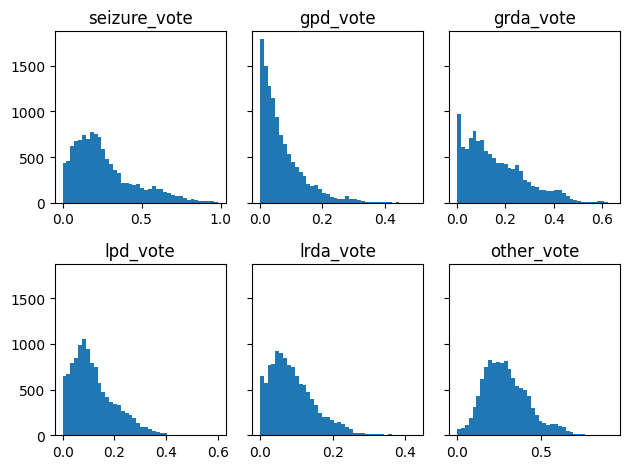

In [11]:
fig, axes = plt.subplots(2, 3, sharey = True)
for i, var in enumerate(results.columns):
    axes[i%2, i//2].hist(results[var], bins = 40)
    axes[i%2, i//2].set_title(var)
fig.tight_layout()
plt.show()
plt.close()

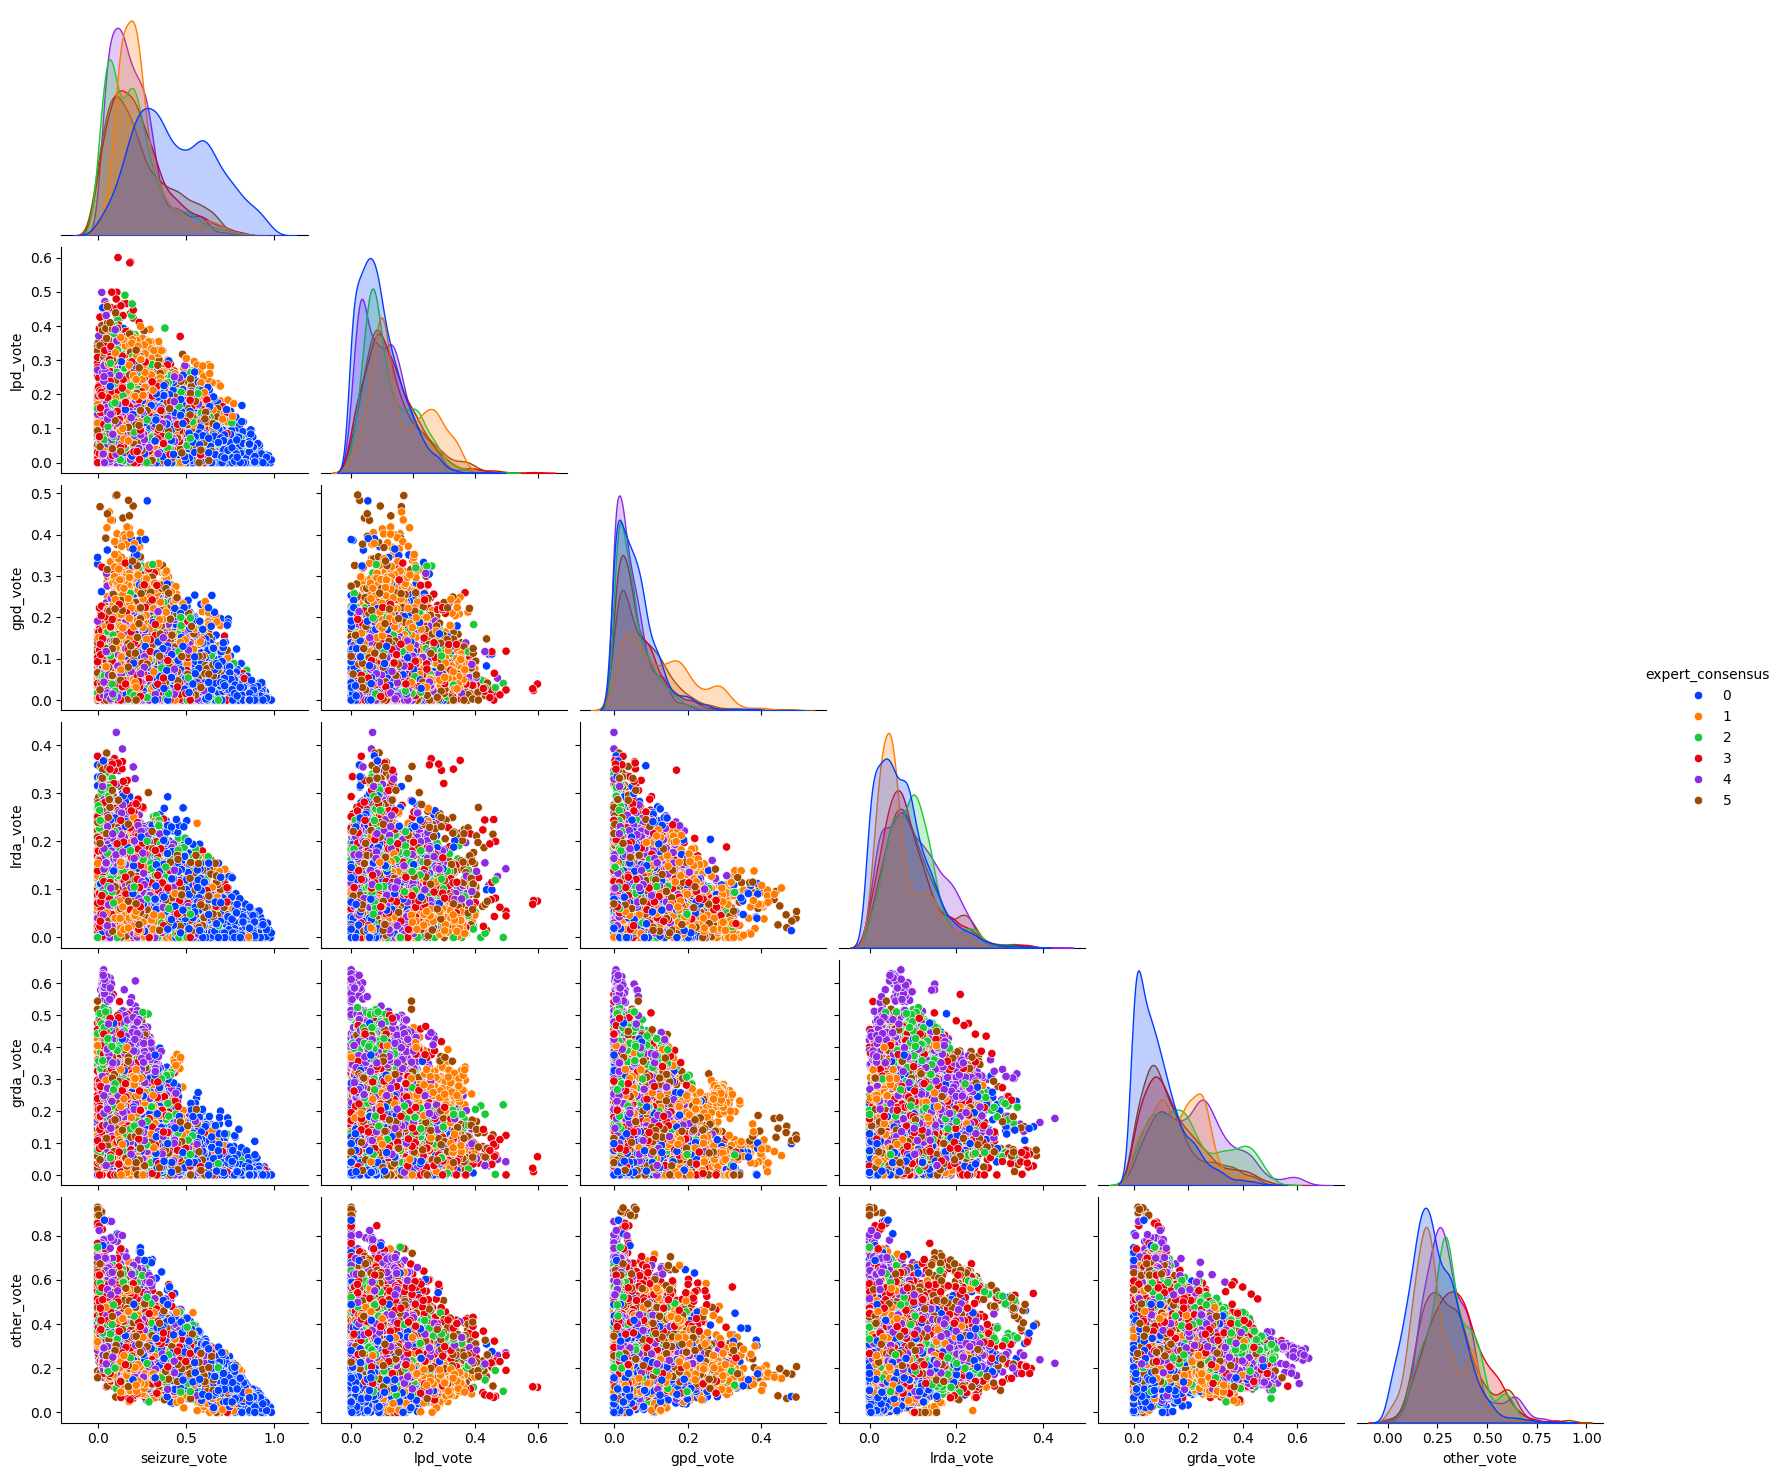

In [13]:
data = pd.concat([results, train.expert_consensus], axis = 1)
sns.pairplot(data.sample(frac=1),
     hue="expert_consensus", 
     corner=True, 
     palette = "bright")
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.savefig(f"{DIRECTORY}pairplot_lgb_class_1.png")
plt.show()
plt.close()

# Model tuning 2

In [ ]:
results['patient_id'] = train['patient_id']
results['eeg_id'] = train['eeg_id']
results_grby_patient = results.groupby('patient_id').mean()
results_grby_eeg_id = results.groupby('eeg_id').mean()
print(results_grby_patient.shape)
print(results_grby_eeg_id.shape)

In [ ]:
list_var = pd.Series(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
for i in list_var:
    results[i+"_patient_avg"] = 0
    results[i+"_eeg_id_avg"] = 0

list_var_avg = list(list_var + "_patient_avg")
for i in results.patient_id.unique():
    mask = results.patient_id == i
    results.loc[mask, list_var_avg] = results_grby_patient.loc[i,list_var].values

list_var_avg = list(list_var + "_eeg_id_avg")
for i in results.eeg_id.unique():
    mask = results.eeg_id == i
    results.loc[mask, list_var_avg] = results_grby_eeg_id.loc[i,list_var].values

results.head(11)

In [ ]:
seizure_vote = train.seizure_vote.copy()
lpd_vote = train.lpd_vote.copy()
gpd_vote = train.gpd_vote.copy()
lrda_vote = train.lrda_vote.copy()
grda_vote = train.grda_vote.copy()
other_vote = train.other_vote.copy()

dict_y = {"seizure_vote": seizure_vote, 
          "lpd_vote": lpd_vote,
          "gpd_vote": gpd_vote,
          "lrda_vote": lrda_vote,
          "grda_vote": grda_vote, 
          "other_vote": other_vote}

Xtrain = results.drop(["patient_id", "eeg_id"], axis = 1).copy()
print(Xtrain.shape)

In [ ]:
def lgb_objective(trial, y):
  params = {'objective': 'regression',
    'metric': 'rmse',
    'max_depth': trial.suggest_int('max_depth', 4,18),
    'num_leaves': trial.suggest_int('num_leaves', 10,40),
    'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.045),
    'n_estimators': trial.suggest_int('n_estimators', 150, 500),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1),
    'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    'max_bin': trial.suggest_int('max_bin', 14,55),
    'device_type': device_type,
    'verbose':-1}
  
  score = custom_CV_lgb(Xtrain, y, params)
  return score

best_params_ = {}
best_values_ = {}

optuna.logging.set_verbosity(optuna.logging.WARNING)

for key, value in dict_y.items():
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: lgb_objective(trial, value), n_trials=25, gc_after_trial = True, n_jobs = 2)
    best_params_[key] = study.best_params
    best_values_[key] = study.best_value
    print(key, study.best_value, study.best_params, "\n\n")

# Model testing 2

In [ ]:
# 18 columns included patient_id and eeg_id
best_params = {
"seizure_vote": # best rmse = 0.34967268983551   
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 13,
'num_leaves': 19,
'learning_rate': 0.03852819511438032,
'n_estimators': 189,
'colsample_bytree': 0.14627032042469215,
'bagging_fraction': 0.2488278760455312,
'reg_alpha': 0.534010847612668,
'reg_lambda': 2.1993222587285866,
'max_bin': 17,
'device_type': device_type,
'verbose':-1},

'lpd_vote': # best rmse = 0.2939234880737899    
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 5,
'num_leaves': 37,
'learning_rate': 0.04140304912415329,
'n_estimators': 242,
'colsample_bytree': 0.4165730452803035,
'bagging_fraction': 0.42966277817490817,
'reg_alpha': 0.42852228530677505,
'reg_lambda': 2.8653314325616592,
'max_bin': 19,
'device_type': device_type,
'verbose':-1},

'gpd_vote': # best rmse = 0.25801604998158845 
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 7,
'num_leaves': 29,
'learning_rate': 0.03007607242097816,
'n_estimators': 155,
'colsample_bytree': 0.2929882062787794,
'bagging_fraction': 0.7858133001534501,
'reg_alpha': 0.20889776310835648,
'reg_lambda': 1.2320375629654818,
'max_bin': 40,
'device_type': device_type,
'verbose':-1},

'lrda_vote': # best rmse = 0.2708719262749392
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 18,
'num_leaves': 39,
'learning_rate': 0.039484424437610265,
'n_estimators': 152,
'colsample_bytree': 0.28101143788113775,
'bagging_fraction': 0.3986914460609911,
'reg_alpha': 0.9611828907505257,
'reg_lambda': 3.88824336582275,
'max_bin': 30,
'device_type': device_type,
'verbose':-1},

'grda_vote': # best rmse: 0.3413220541967568
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 11,
'num_leaves': 17,
'learning_rate': 0.03798936064765961,
'n_estimators': 183,
'colsample_bytree': 0.6210897848730615,
'bagging_fraction': 0.2890898603820952,
'reg_alpha': 0.5111276987914602,
'reg_lambda': 2.3073688678137234,
'max_bin': 24,
'device_type': device_type,
'verbose':-1},

'other_vote': # best rmse: 0.29563356704931776
{'objective': 'regression',
'metric': 'rmse',
'max_depth': 4,
'num_leaves': 31,
'learning_rate': 0.03443512669187556,
'n_estimators': 153,
'colsample_bytree': 0.4270270616259836,
'bagging_fraction': 0.9976971072465282,
'reg_alpha': 0.9524891321705151,
'reg_lambda': 1.1273749815826584,
'max_bin': 43,
'device_type': device_type,
'verbose':-1}
}

In [ ]:
results = CV_predictions_lgb(Xtrain, dict_y, best_params, n_splits = 5)
print(results.head(10))

In [ ]:
y_df = np.zeros_like(results)
for i, key in enumerate(dict_y.keys()):
    y_df[:,i] = dict_y[key]

kld = kl_divergence(y_df, results.values)
print(f"LGBM competition KLD, no micro average: {kld}")
kld = kl_divergence(y_df, results.values, micro_average = True)
print(f"LGBM competition KLD, with micro average: {kld}")
KL = KLDivergence()
kld = KL(y_df,  results.values).numpy()
print(f"LGBM keras KLD: {kld}")
jsd = JensenShannonDiv(y_df, results.values)
print(f"LGBM JSD: {jsd}")

# Model testing 3 Neural Network

In [ ]:
import copy
import os
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.losses import KLDivergence
import keras.backend as K

In [ ]:
var = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

y_df = pd.DataFrame(np.zeros((train.shape[0], 6)))
y_df.columns = var
for i in ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]:
    y_df.loc[:,i] = train[i]

print(y_df.shape)
print(Xtrain.shape)

In [ ]:
def JSD_NN(y_true, y_pred): # Jensen-Shannon Divergence https://towardsdatascience.com/how-to-understand-and-use-jensen-shannon-divergence-b10e11b03fd6
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)
    # removing 0 to avoid divisions by 0.
    y_pred = tf.where(tf.equal(y_pred, 0.0), 1e-15, y_pred)
    y_true = tf.where(tf.equal(y_true, 0.0), 1e-15, y_true)
    # sum to 1
    y_true = tf.transpose(y_true) / tf.math.reduce_sum(y_true, axis = 1)
    y_true = tf.transpose(y_true)
    y_pred = tf.transpose(y_pred) / tf.math.reduce_sum(y_pred, axis = 1)
    y_pred = tf.transpose(y_pred)
    # calculate JSD
    JSD1 = y_pred*tf.math.log(2* y_pred/ (y_pred+y_true))
    JSD2 = y_true*tf.math.log(2* y_true/ (y_pred+y_true))
    JSD = 0.5*tf.math.reduce_sum(JSD1, axis = 1) + 0.5*tf.math.reduce_sum(JSD2, axis = 1)
    return tf.math.reduce_mean(JSD)


In [ ]:
def CV_predictions_kerasTF(X, y_df, n_splits = 5, input_shape = (18,), extra_layer = None, dropout = 0.1,
                           learning_rate = 1e-3, batch_size = 32, epochs = 100, patience = 10, verbose = 1):
    CV_predictions = pd.DataFrame(np.zeros([len(X),6]))
    CV_predictions.columns = y_df.columns
    
    unique_patient_id = pd.Series(train.patient_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_patient_id)
    mykFolds = enumerate(skfold.split(unique_patient_id))

    NN_models = {}
    
    for i, (train_idx, test_idx) in mykFolds:
        print("---", i)
        mask = train.patient_id.isin(unique_patient_id.iloc[train_idx])
        X_train = X.loc[mask,:].values
        X_test = X.loc[~mask,:].values

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        y_train = y_df.loc[mask,:].values
        y_test = y_df.loc[~mask,:].values

        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)
        print("X_test shape", X_test.shape)
        
        mA0 = keras.layers.Input(shape=input_shape, name = "inputA")
        mA1 = keras.layers.Dense(int(input_shape[0]*0.8), activation="relu")(mA0)
        if extra_layer != None:
            mA2 = keras.layers.Dense(extra_layer, activation="relu")(mA1)
            mA3 = keras.layers.Dropout(0.1)(mA2)
        else:
            mA3 = keras.layers.Dropout(0.1)(mA1)
        output_layer = keras.layers.Dense(6, activation = "softmax")(mA3)
        model = keras.models.Model(inputs=[mA0], outputs=output_layer, name = f"NN_model_{key}")

        model.compile(
            loss= JSD_NN,
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=[JSD_NN],
        )
        if i == 0: print(model.summary())

        callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)]
        
        model.fit(
            [X_train],
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.15,
            callbacks=callbacks,
            verbose=verbose
        )

        NN_models[i] = model
        
        pred = model.predict(X_test)
        CV_predictions.loc[~mask,:] = pred
        
        gc.collect()

    # rows should sum to 1 (as result of clipping)
    total = CV_predictions.sum(axis = 1).values
    CV_predictions = CV_predictions.T / total
    CV_predictions = CV_predictions.T

    tf.keras.backend.clear_session()

    return CV_predictions

In [ ]:
tf.keras.backend.clear_session()
results = CV_predictions_kerasTF(Xtrain, y_df, n_splits = 5, input_shape = (Xtrain.shape[1],), extra_layer = 80, dropout = 0.1,
                           learning_rate = 5e-4, batch_size = 32, epochs = 100, patience = 6, verbose = 1)
print(results.head(10))

In [ ]:
kld = kl_divergence(y_df.values, results.values)
print(f"LGBM competition KLD, no micro average: {kld}")
kld = kl_divergence(y_df.values, results.values, micro_average = True)
print(f"LGBM competition KLD, with micro average: {kld}")
KL = KLDivergence()
kld = KL(y_df.values,  results.values).numpy()
print(f"LGBM keras KLD: {kld}")
jsd = JensenShannonDiv(y_df.values, results.values)
print(f"LGBM JSD: {jsd}")

In [ ]:
results['patient_id'] = train['patient_id']
results['eeg_id'] = train['eeg_id']
results_grby_patient = results.groupby('patient_id').mean()
results_grby_eeg_id = results.groupby('eeg_id').mean()
print(results_grby_patient.shape)
print(results_grby_eeg_id.shape)

list_var = pd.Series(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
for i in list_var:
    results[i+"_patient_avg"] = 0
    results[i+"_eeg_id_avg"] = 0

list_var_avg = list(list_var + "_patient_avg")
for i in results.patient_id.unique():
    mask = results.patient_id == i
    results.loc[mask, list_var_avg] = results_grby_patient.loc[i,list_var].values

list_var_avg = list(list_var + "_eeg_id_avg")
for i in results.eeg_id.unique():
    mask = results.eeg_id == i
    results.loc[mask, list_var_avg] = results_grby_eeg_id.loc[i,list_var].values

results.head(11)

# Neural Network optimization

In [14]:
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.losses import KLDivergence

Num GPUs Available:  1


In [15]:
results['patient_id'] = train['patient_id']
results['eeg_id'] = train['eeg_id']
results_grby_patient = results.groupby('patient_id').mean()
results_grby_eeg_id = results.groupby('eeg_id').mean()
print(results_grby_patient.shape)
print(results_grby_eeg_id.shape)

(644, 7)
(1694, 7)


In [16]:
list_var = pd.Series(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
for i in list_var:
    results[i+"_patient_avg"] = 0
    results[i+"_eeg_id_avg"] = 0

list_var_avg = list(list_var + "_patient_avg")
for i in results.patient_id.unique():
    mask = results.patient_id == i
    results.loc[mask, list_var_avg] = results_grby_patient.loc[i,list_var].values

list_var_avg = list(list_var + "_eeg_id_avg")
for i in results.eeg_id.unique():
    mask = results.eeg_id == i
    results.loc[mask, list_var_avg] = results_grby_eeg_id.loc[i,list_var].values

results.head(11)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,patient_id,eeg_id,seizure_vote_patient_avg,seizure_vote_eeg_id_avg,lpd_vote_patient_avg,lpd_vote_eeg_id_avg,gpd_vote_patient_avg,gpd_vote_eeg_id_avg,lrda_vote_patient_avg,lrda_vote_eeg_id_avg,grda_vote_patient_avg,grda_vote_eeg_id_avg,other_vote_patient_avg,other_vote_eeg_id_avg
0,0.351303,1.414855e-02,0.085903,0.171796,0.129847,0.247002,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
1,0.372532,3.640797e-02,0.073438,0.151926,0.149302,0.216395,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
2,0.322400,5.735164e-02,0.101978,0.155454,0.143948,0.218869,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
3,0.395631,1.885872e-03,0.095990,0.149738,0.098037,0.258718,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
4,0.447715,1.000000e-15,0.117911,0.151318,0.060085,0.222972,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
5,0.419135,1.000000e-15,0.110159,0.145486,0.091521,0.233699,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
6,0.422121,1.000000e-15,0.123531,0.178730,0.056142,0.219477,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
7,0.427705,1.000000e-15,0.120220,0.171194,0.035893,0.244987,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
8,0.402773,1.000000e-15,0.119812,0.176735,0.027956,0.272725,42516,1628180742,0.395702,0.395702,0.012199,0.012199,0.105438,0.105438,0.161375,0.161375,0.088081,0.088081,0.237205,0.237205
9,0.241719,3.602413e-02,0.076615,0.089571,0.050403,0.505668,30539,2277392603,0.152398,0.263275,0.109175,0.033748,0.260961,0.089406,0.035128,0.075323,0.234165,0.050077,0.208172,0.488170


In [17]:
var = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

y_df = pd.DataFrame(np.zeros((train.shape[0], 6)))
y_df.columns = var
for i in ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]:
    y_df.loc[:,i] = train[i]

print(y_df.shape)

(11425, 6)


In [18]:
Xtrain = results.drop(["patient_id", "eeg_id"], axis = 1).copy()
print(Xtrain.shape)

(11425, 18)


In [19]:
def JSD_NN(y_true, y_pred): # Jensen-Shannon Divergence https://towardsdatascience.com/how-to-understand-and-use-jensen-shannon-divergence-b10e11b03fd6
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)
    # removing 0 to avoid divisions by 0.
    y_pred = tf.where(tf.equal(y_pred, 0.0), 1e-15, y_pred)
    y_true = tf.where(tf.equal(y_true, 0.0), 1e-15, y_true)
    # sum to 1
    y_true = tf.transpose(y_true) / tf.math.reduce_sum(y_true, axis = 1)
    y_true = tf.transpose(y_true)
    y_pred = tf.transpose(y_pred) / tf.math.reduce_sum(y_pred, axis = 1)
    y_pred = tf.transpose(y_pred)
    # calculate JSD
    JSD1 = y_pred*tf.math.log(2* y_pred/ (y_pred+y_true))
    JSD2 = y_true*tf.math.log(2* y_true/ (y_pred+y_true))
    JSD = 0.5*tf.math.reduce_sum(JSD1, axis = 1) + 0.5*tf.math.reduce_sum(JSD2, axis = 1)
    return tf.math.reduce_mean(JSD)

In [20]:
def CV_predictions_kerasTF(X, y_df, n_splits = 5, input_shape = (18,), extra_layer = None, dropout = 0.1,
                           learning_rate = 1e-3, batch_size = 32, epochs = 100, patience = 10, verbose = 1):
    CV_predictions = pd.DataFrame(np.zeros([len(X),6]))
    CV_predictions.columns = y_df.columns
    
    unique_patient_id = pd.Series(train.patient_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_patient_id)
    mykFolds = enumerate(skfold.split(unique_patient_id))

    NN_models = {}
    
    for i, (train_idx, test_idx) in mykFolds:
        print("---", i)
        mask = train.patient_id.isin(unique_patient_id.iloc[train_idx])
        X_train = X.loc[mask,:].values
        X_test = X.loc[~mask,:].values

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        y_train = y_df.loc[mask,:].values
        y_test = y_df.loc[~mask,:].values

        print("X_train shape:", X_train.shape)
        print("y_train shape:", y_train.shape)
        print("X_test shape", X_test.shape)
        
        mA0 = keras.layers.Input(shape=input_shape, name = "inputA")
        mA1 = keras.layers.Dense(int(input_shape[0]*0.8), activation="relu")(mA0)
        if extra_layer != None:
            mA2 = keras.layers.Dense(extra_layer, activation="relu")(mA1)
            mA3 = keras.layers.Dropout(0.1)(mA2)
        else:
            mA3 = keras.layers.Dropout(0.1)(mA1)
        output_layer = keras.layers.Dense(6, activation = "softmax")(mA3)
        model = keras.models.Model(inputs=[mA0], outputs=output_layer, name = f"NN_model_{key}")

        model.compile(
            loss= JSD_NN,
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=[JSD_NN],
        )
        if i == 0: print(model.summary())

        callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience)]
        
        model.fit(
            [X_train],
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=verbose
        )

        NN_models[i] = model
        
        pred = model.predict(X_test)
        CV_predictions.loc[~mask,:] = pred
        
        gc.collect()

    # rows should sum to 1 (as result of clipping)
    total = CV_predictions.sum(axis = 1).values
    CV_predictions = CV_predictions.T / total
    CV_predictions = CV_predictions.T

    tf.keras.backend.clear_session()

    return CV_predictions

In [21]:
tf.keras.backend.clear_session()
results = CV_predictions_kerasTF(Xtrain, y_df, n_splits = 5, input_shape = (Xtrain.shape[1],), extra_layer = None, dropout = 0.1,
                           learning_rate = 5e-4, batch_size = 32, epochs = 50, patience = 6, verbose = 1)
print(results.head(10))

--- 0
X_train shape: (8919, 18)
y_train shape: (8919, 6)
X_test shape (2506, 18)
Model: "NN_model_other_vote"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputA (InputLayer)         [(None, 18)]              0         
                                                                 
 dense (Dense)               (None, 14)                266       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 90        
                                                                 
Total params: 356
Trainable params: 356
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
237/237 [==============================] - 3s 9ms/step - loss: 0.3613 - JSD_NN: 0.36

In [22]:
kld = kl_divergence(y_df.values, results.values)
print(f"LGBM competition KLD, no micro average: {kld}")
kld = kl_divergence(y_df.values, results.values, micro_average = True)
print(f"LGBM competition KLD, with micro average: {kld}")
KL = KLDivergence()
kld = KL(y_df.values,  results.values).numpy()
print(f"LGBM keras KLD: {kld}")
jsd = JensenShannonDiv(y_df.values, results.values)
print(f"LGBM JSD: {jsd}")

LGBM competition KLD, no micro average: 0.34921326572271744
LGBM competition KLD, with micro average: 2.0952795943363043
LGBM keras KLD: 2.0939806588625207
LGBM JSD: 0.34423765452878424


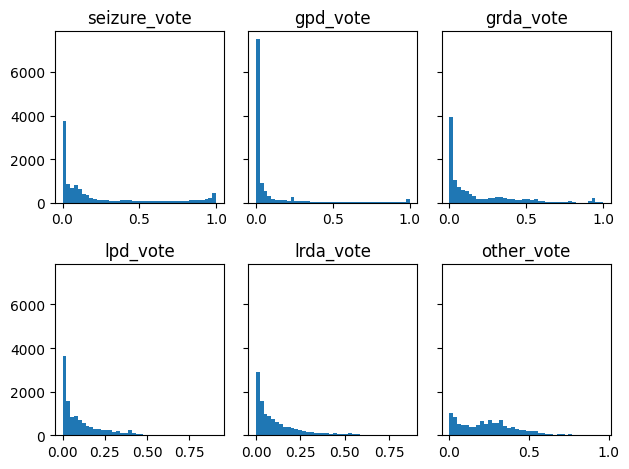

In [23]:
fig, axes = plt.subplots(2, 3, sharey = True)
for i, var in enumerate(results.columns):
    axes[i%2, i//2].hist(results[var], bins = 40)
    axes[i%2, i//2].set_title(var)
fig.tight_layout()
plt.show()
plt.close()

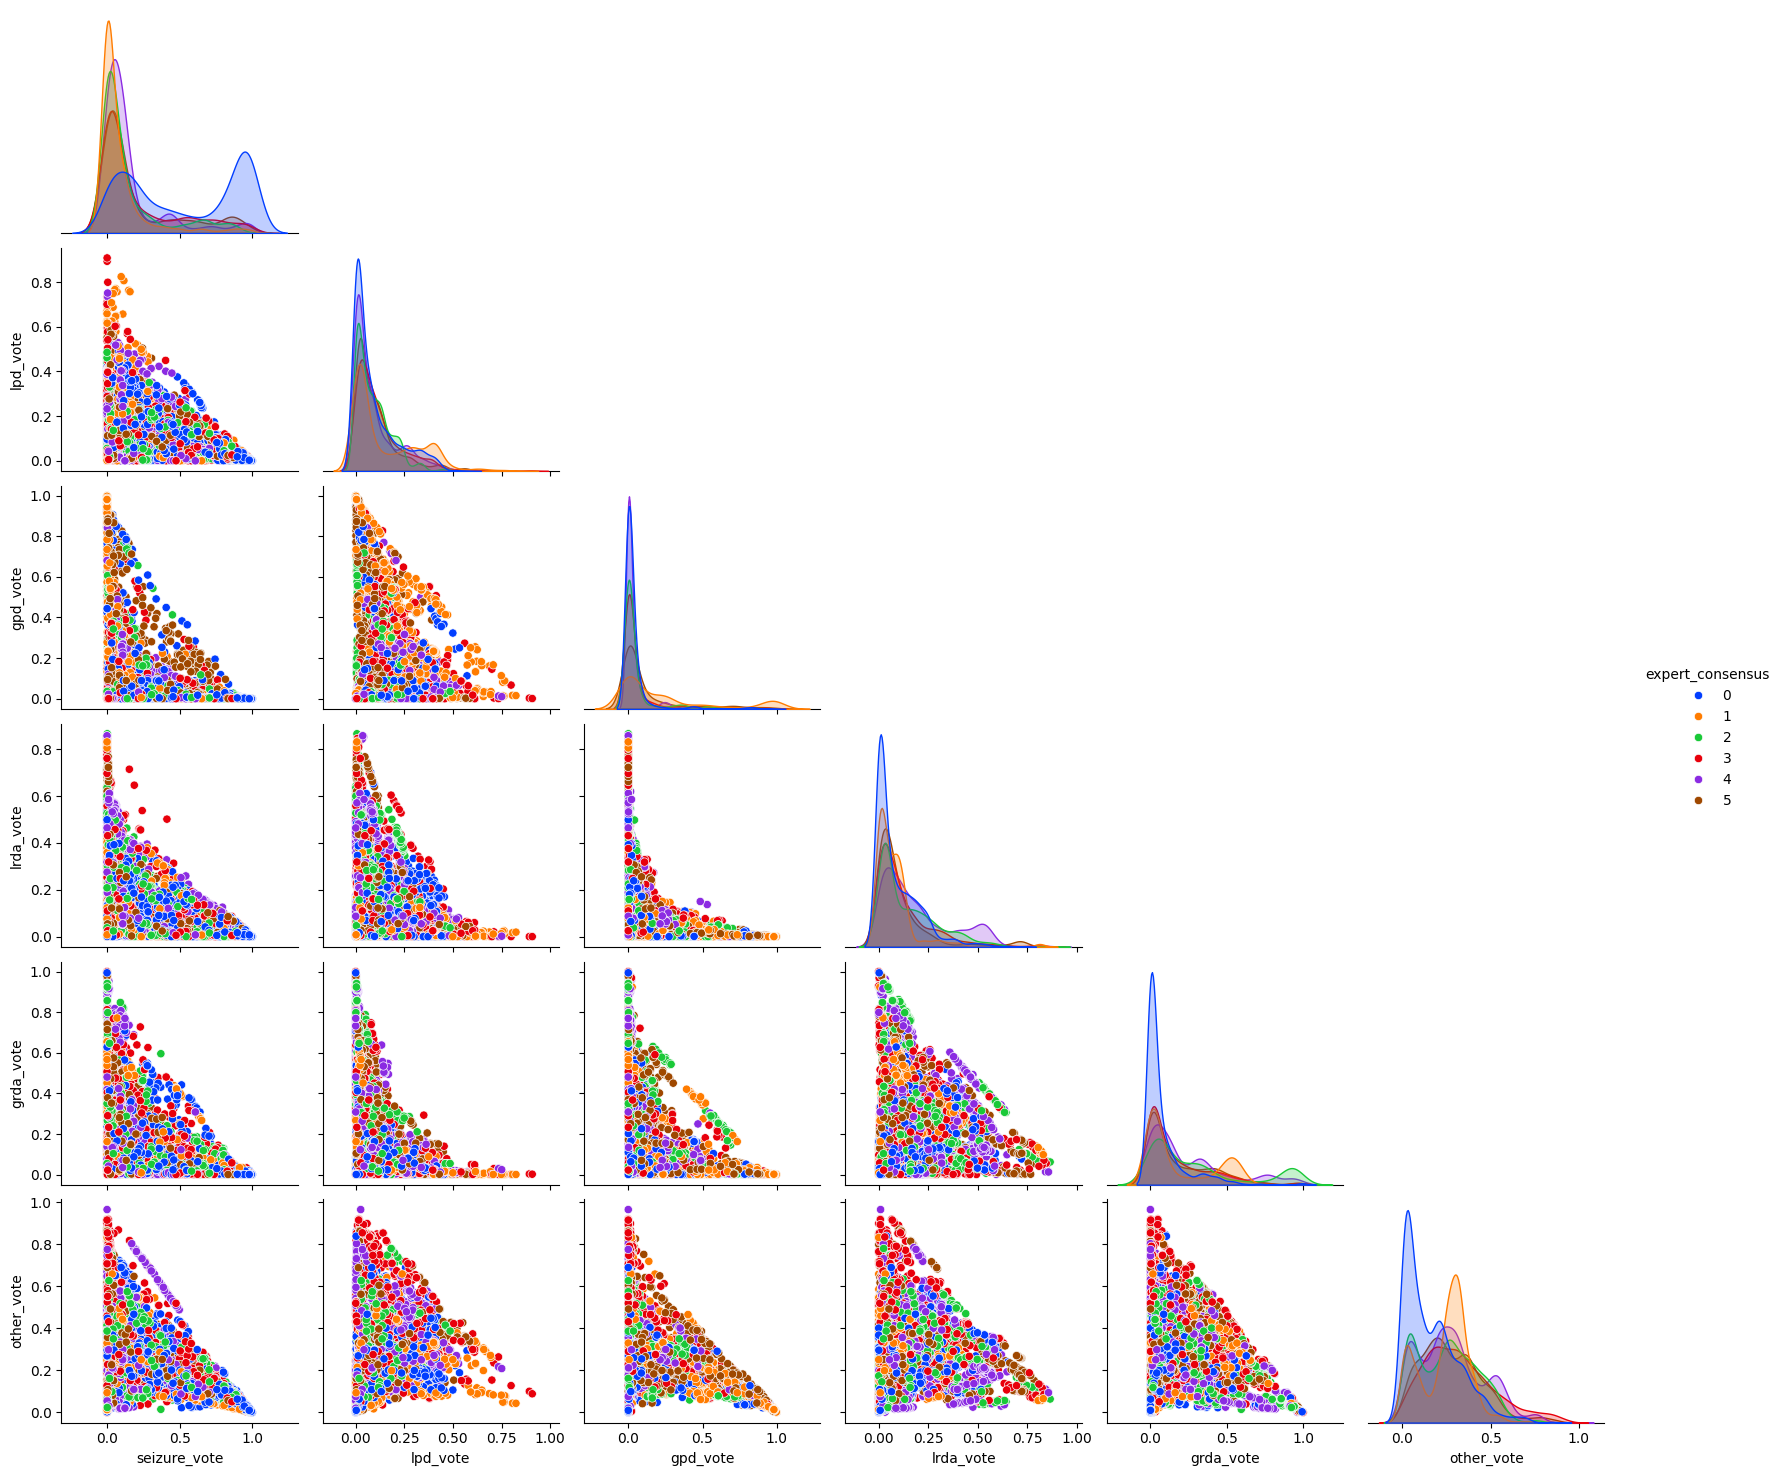

In [24]:
data = pd.concat([results, train.expert_consensus], axis = 1)
sns.pairplot(data.sample(frac=1),
     hue="expert_consensus", 
     corner=True, 
     palette = "bright")
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.savefig(f"{DIRECTORY}pairplot_lgb_class_2.png")
plt.show()
plt.close()

# Categorization preparation

In [25]:
results['patient_id'] = train['patient_id']
results['eeg_id'] = train['eeg_id']
results_grby_patient = results.groupby('patient_id').mean()
results_grby_eeg_id = results.groupby('eeg_id').mean()
print(results_grby_patient.shape)
print(results_grby_eeg_id.shape)

(644, 7)
(1694, 7)


In [ ]:
list_var = pd.Series(['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
for i in list_var:
    results[i+"_patient_avg"] = 0
    results[i+"_eeg_id_avg"] = 0

list_var_avg = list(list_var + "_patient_avg")
for i in results.patient_id.unique():
    mask = results.patient_id == i
    results.loc[mask, list_var_avg] = results_grby_patient.loc[i,list_var].values

list_var_avg = list(list_var + "_eeg_id_avg")
for i in results.eeg_id.unique():
    mask = results.eeg_id == i
    results.loc[mask, list_var_avg] = results_grby_eeg_id.loc[i,list_var].values

results.head(11)

In [ ]:
Xtrain = results.drop(["patient_id", "eeg_id"], axis = 1).copy()
print(Xtrain.shape)

In [ ]:
var = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
y_df["Class"] = y_df.index
y_df["Class"] = y_df["Class"].apply(lambda x: "%s"%(y_df.loc[x,var].round(1).values))
y_df.head(15)

In [ ]:
classes = ["[1. 0. 0. 0. 0. 0.]",
           "[0. 1. 0. 0. 0. 0.]",
           "[0. 0. 1. 0. 0. 0.]",
           "[0. 0. 0. 1. 0. 0.]",
           "[0. 0. 0. 0. 1. 0.]",
           "[0. 0. 0. 0. 0. 1.]"]

y_df["Class2"] = y_df.index
y_df["Class2"] = y_df["Class2"].apply(lambda x: y_df.loc[x,"Class"] if y_df.loc[x,"Class"] in classes else "[0]")
y_df["Class2"].value_counts()

In [ ]:
class_encoding = {}
class_decoding = {}

for i, value in enumerate(y_df["Class2"].unique()):
    class_encoding[value] = i
    class_decoding[i] = value
    y_df["Class2"] = y_df["Class2"].replace(value, i)

ytrain = y_df["Class2"].copy()
ytrain.value_counts()

# categorization tuning

In [ ]:
from sklearn.metrics import accuracy_score, log_loss

In [ ]:
def custom_CV_lgb(X, y, params, n_splits = 5):
    CV_predictions = pd.DataFrame(np.zeros([y.shape[0],7]))
    
    unique_patient_id = pd.Series(train.patient_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_patient_id)
    mykFolds = enumerate(skfold.split(unique_patient_id))

    LGBM = lgb.LGBMRegressor(**params)
    
    for i, (train_idx, test_idx) in mykFolds:
        mask = train.patient_id.isin(unique_patient_id.iloc[train_idx])
        X_train = X.loc[mask,:]
        y_train = y.loc[mask]
        X_test = X.loc[~mask,:]
        y_test = y.loc[~mask]

        LGBM.fit(X_train, y_train)
        pred = LGBM.predict(X_test)
          
        # build CV results
        CV_predictions.iloc[~mask,:] = pred
        gc.collect()

    results = log_loss(y, CV_predictions)
    print(f"LGBM log loss: {results}")

    return results

In [ ]:
def lgb_objective(trial, y):
  params = {'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_classes':7,
    'max_depth': trial.suggest_int('max_depth', 22,30),
    'num_leaves': trial.suggest_int('num_leaves', 110,130),
    'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.035),
    'n_estimators': trial.suggest_int('n_estimators', 100, 130),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.7),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 0.7),
    'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 1),
    'reg_lambda': trial.suggest_float('reg_lambda', 5, 7),
    'max_bin': trial.suggest_int('max_bin', 10,35),
    'device_type': device_type,
    'verbose':-1}
  
  score = custom_CV_lgb(Xtrain, y, params)
  return score

best_params_ = 0
best_values_ = 0

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: lgb_objective(trial, ytrain), n_trials=10, gc_after_trial = True, n_jobs = 2)
best_params_ = study.best_params
best_values_ = study.best_value
print(study.best_value, study.best_params, "\n\n")

# test categorization

In [ ]:
print(class_decoding)

In [ ]:
params = { # best log loss 1.4355722220887932  
'objective': 'multiclass',
'metric': 'multi_logloss',
'num_classes':7,
'max_depth': 25,
'num_leaves': 119,
'learning_rate': 0.031176560364717477,
'n_estimators': 117,
'colsample_bytree': 0.11547199247823513,
'bagging_fraction': 0.5247270521645587,
'reg_alpha': 0.8605788356963568,
'reg_lambda': 5.083433401989845, 
'max_bin': 22,
'device_type': device_type,
'verbose':-1
}


def CV_predictions_lgb(X, y, params, n_splits = 5):
    CV_predictions = pd.DataFrame(np.zeros([y.shape[0],7]))
    
    unique_patient_id = pd.Series(train.patient_id.unique())
    skfold = KFold(n_splits = n_splits, shuffle = True)
    skfold.get_n_splits(unique_patient_id)
    mykFolds = enumerate(skfold.split(unique_patient_id))

    LGBM = lgb.LGBMRegressor(**params)
    
    for i, (train_idx, test_idx) in mykFolds:
        mask = train.patient_id.isin(unique_patient_id.iloc[train_idx])
        X_train = X.loc[mask,:]
        y_train = y.loc[mask]
        X_test = X.loc[~mask,:]
        y_test = y.loc[~mask]

        LGBM.fit(X_train, y_train)
        pred = LGBM.predict(X_test)
          
        # build CV results
        CV_predictions.iloc[~mask,:] = pred
        gc.collect()
    
    LL = log_loss(y, CV_predictions)
    print(f"LGBM log loss: {LL}")

    results = CV_predictions.idxmax(axis = 1)
    print(results.shape)
    print(CV_predictions.shape)
    CV_predictions["Class"] = results.values

    return CV_predictions


new_var = ['seizure_class_proba', 'other_other', 'lrda_class_proba', 'other_class_proba', 'grda_class_proba', 
           'gpd_class_proba', 'lpd_class_proba', 'Class']
results[new_var] = CV_predictions_lgb(Xtrain, ytrain, params, n_splits = 5)
results.head()

In [ ]:
sns.pairplot(results[new_var].sample(frac=1),
     hue="Class", 
     corner=True, 
     palette = "bright")
fig = plt.gcf()
fig.set_size_inches(18, 15)
plt.savefig(f"{DIRECTORY}pairplot_lgb_class.png")
plt.show()
plt.close()

In [ ]:
results.Class.value_counts()

In [ ]:
dict_replace = {'seizure_vote': ([1,0,0,0,0,0], 'seizure_class_proba'),
                'lpd_vote': ([0,1,0,0,0,0], 'lpd_class_proba'),
                'gpd_vote': ([0,0,1,0,0,0], 'gpd_class_proba'),
                'lrda_vote': ([0,0,0,1,0,0], 'lrda_class_proba'),
                'grda_vote': ([0,0,0,0,1,0], 'grda_class_proba'),
                'other_vote': ([0,0,0,0,0,1], 'other_class_proba')}

dict_replace_2 = {0: ([1,0,0,0,0,0], 'seizure_class_proba'),
                6: ([0,1,0,0,0,0], 'lpd_class_proba'),
                5: ([0,0,1,0,0,0], 'gpd_class_proba'),
                2: ([0,0,0,1,0,0], 'lrda_class_proba'),
                4: ([0,0,0,0,1,0], 'grda_class_proba'),
                3: ([0,0,0,0,0,1], 'other_class_proba')}

for i in dict_replace_2.keys():
    mask = results.Class == i
    results.loc[mask, dict_replace.keys()] = dict_replace_2[i][0]

results.head(11)

In [ ]:
var = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

kld = kl_divergence(y_df[var].values, results[var].values)
print(f"LGBM competition KLD, no micro average: {kld}")
kld = kl_divergence(y_df[var].values, results[var].values, micro_average = True)
print(f"LGBM competition KLD, with micro average: {kld}")
KL = KLDivergence()
kld = KL(y_df[var].values,  results[var].values).numpy()
print(f"LGBM keras KLD: {kld}")
jsd = JensenShannonDiv(y_df[var].values, results[var].values)
print(f"LGBM JSD: {jsd}")